# Time series analysis with statsmodels

# Data

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv('./Data/hotel_bookings.csv')\
    .rename(columns={'arrival_date_year':'year','arrival_date_month':'month','arrival_date_day_of_month':'day'})
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119390 entries, 0 to 119389
Data columns (total 32 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   hotel                           119390 non-null  object 
 1   is_canceled                     119390 non-null  int64  
 2   lead_time                       119390 non-null  int64  
 3   year                            119390 non-null  int64  
 4   month                           119390 non-null  object 
 5   arrival_date_week_number        119390 non-null  int64  
 6   day                             119390 non-null  int64  
 7   stays_in_weekend_nights         119390 non-null  int64  
 8   stays_in_week_nights            119390 non-null  int64  
 9   adults                          119390 non-null  int64  
 10  children                        119386 non-null  float64
 11  babies                          119390 non-null  int64  
 12  meal            

In [2]:
df['hotel'].unique()

array(['Resort Hotel', 'City Hotel'], dtype=object)

In [3]:
df['month'].unique()

array(['July', 'August', 'September', 'October', 'November', 'December',
       'January', 'February', 'March', 'April', 'May', 'June'],
      dtype=object)

In [4]:
def monthToNum(shortMonth):
    return {
            'January': 1,
            'February': 2,
            'March': 3,
            'April': 4,
            'May': 5,
            'June': 6,
            'July': 7,
            'August': 8,
            'September': 9, 
            'October': 10,
            'November': 11,
            'December': 12
    }[shortMonth]

In [5]:
df['month'] = df['month'].apply(monthToNum)
df['date']= pd.to_datetime(df[["year", "month", "day"]])



# granger causality tests

The Granger causality test is a statistical test used to assess the causal relationship between two variables in a time series context. It is based on the idea that if variable X "Granger causes" variable Y, then the past values of X should contain information that helps predict the future values of Y beyond what can be predicted from the lagged values of Y alone.

In [6]:
r_df = df[(df['is_canceled']==0)& (df['hotel']=='Resort Hotel')]
c_df = df[(df['is_canceled']==0)& (df['hotel']=='City Hotel')]
r_df = r_df.groupby(['date']).size().reset_index().set_index('date').rename(columns={0:'Resort Hotel'})
c_df = c_df.groupby(['date']).size().reset_index().set_index('date').rename(columns={0:'City Hotel'})
g_df = pd.concat([r_df, c_df], axis=1).fillna(0)

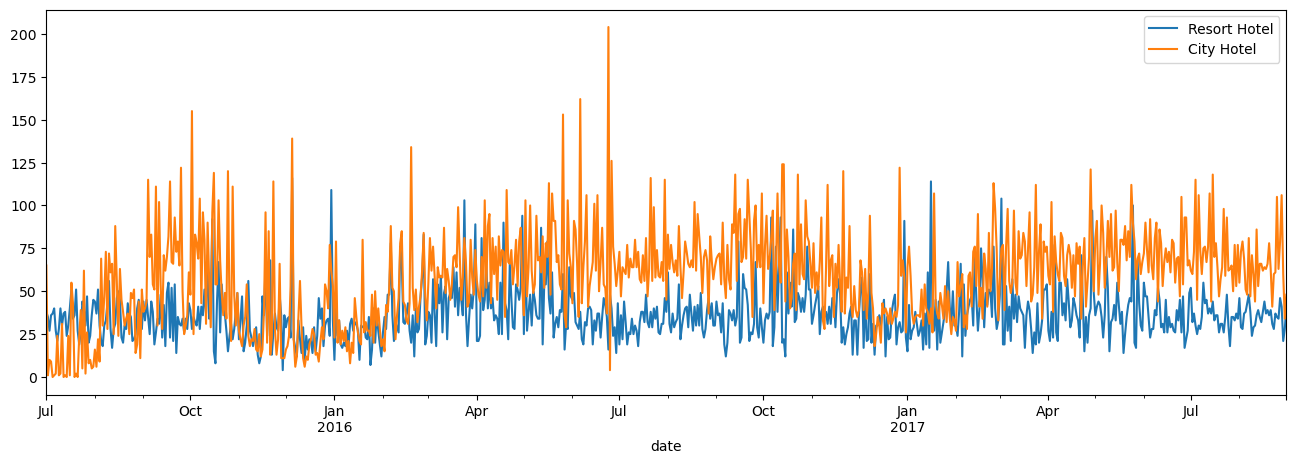

In [7]:
g_df.index.freq = 'D'
g_df[['Resort Hotel','City Hotel']].plot(figsize=(16,5));

In [8]:
from statsmodels.tsa.stattools import grangercausalitytests
grangercausalitytests(g_df[['Resort Hotel','City Hotel']],maxlag=3);


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=5.3907  , p=0.0205  , df_denom=789, df_num=1
ssr based chi2 test:   chi2=5.4112  , p=0.0200  , df=1
likelihood ratio test: chi2=5.3928  , p=0.0202  , df=1
parameter F test:         F=5.3907  , p=0.0205  , df_denom=789, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=2.9273  , p=0.0541  , df_denom=786, df_num=2
ssr based chi2 test:   chi2=5.8919  , p=0.0526  , df=2
likelihood ratio test: chi2=5.8700  , p=0.0531  , df=2
parameter F test:         F=2.9273  , p=0.0541  , df_denom=786, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=4.8512  , p=0.0024  , df_denom=783, df_num=3
ssr based chi2 test:   chi2=14.6837 , p=0.0021  , df=3
likelihood ratio test: chi2=14.5489 , p=0.0022  , df=3
parameter F test:         F=4.8512  , p=0.0024  , df_denom=783, df_num=3


In [9]:
from statsmodels.tsa.stattools import adfuller
result = adfuller(g_df['Resort Hotel'].dropna())
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')

ADF Statistic: -4.667468361101857
p-value: 9.682658988301675e-05


In [10]:
result = adfuller(g_df['City Hotel'].dropna())
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')

ADF Statistic: -3.50978567854219
p-value: 0.007739305068788133


In [11]:
g_df

,Resort Hotel,City Hotel
date,,
2015-07-01,38,65.0
2015-07-02,35,1.0
2015-07-03,27,10.0
2015-07-04,36,9.0
2015-07-05,37,0.0
...,...,...
2017-08-27,46,79.0
2017-08-28,41,106.0
2017-08-29,21,60.0


VAR (Vector Autoregression):
VAR is a multivariate time series model that captures the interdependencies and dynamic interactions between multiple variables. It extends the concept of autoregression, which models a variable's behavior based on its own lagged values, to multiple variables simultaneously.

In [12]:
from statsmodels.tsa.api import VAR
nobs=30
train, test = g_df[0:-nobs], g_df[-nobs:]

for i in [1,2,3,4,5,6,7]:
    model = VAR(train)
    results = model.fit(i)
    print('Order =', i)
    print('AIC: ', results.aic)
    print('BIC: ', results.bic)
    print()

Order = 1
AIC:  12.066068099592734
BIC:  12.102571615779242

Order = 2
AIC:  11.973916020693899
BIC:  12.034817904502857

Order = 3
AIC:  11.878624395507458
BIC:  11.96397499822578

Order = 4
AIC:  11.838199155244661
BIC:  11.948048999767877

Order = 5
AIC:  11.83489469327847
BIC:  11.969294474919806

Order = 6
AIC:  11.8385692149101
BIC:  11.997569802214425

Order = 7
AIC:  11.758126088260152
BIC:  11.941778523822832



In [13]:
test

,Resort Hotel,City Hotel
date,,
2017-08-02,29,73.0
2017-08-03,28,79.0
2017-08-04,37,69.0
2017-08-05,38,51.0
2017-08-06,43,48.0
2017-08-07,48,81.0
2017-08-08,38,47.0
2017-08-09,24,71.0
2017-08-10,29,60.0


In [14]:
results = model.fit(5)
results.summary()

lag_order = results.k_ar
z = results.forecast(y=train.values[-lag_order:], steps=30)
z

array([[36.07147157, 62.94613374],
       [37.73265688, 64.93861694],
       [36.73161679, 60.903408  ],
       [37.24873945, 63.00139075],
       [37.41248931, 61.15422451],
       [36.83379527, 61.87907703],
       [37.00945556, 61.43421098],
       [36.88261978, 61.02738188],
       [36.92114191, 61.05991508],
       [36.87889894, 60.76260605],
       [36.83110247, 60.67153076],
       [36.83347905, 60.48847972],
       [36.80690492, 60.36146414],
       [36.79574683, 60.25327807],
       [36.77859563, 60.1298208 ],
       [36.76566079, 60.03436238],
       [36.7553465 , 59.93945643],
       [36.74353688, 59.85652104],
       [36.73418071, 59.7793745 ],
       [36.72509736, 59.70824293],
       [36.71706667, 59.64473833],
       [36.70966623, 59.58588703],
       [36.70281793, 59.53246027],
       [36.6966982 , 59.48356907],
       [36.69104263, 59.43898562],
       [36.68589989, 59.39833325],
       [36.68119863, 59.36114278],
       [36.67690892, 59.32723602],
       [36.6729984 ,

# Univariate 

In [15]:
df = df[(df['is_canceled']==0) & (df['hotel']=='Resort Hotel')]
t_df = df.groupby(['date'])['hotel'].count().reset_index().rename(columns={'hotel':'y','date':'ds'})


In [16]:
import plotly.express as px

fig = px.line(t_df, x="ds", y="y", title='hotel demands')
fig.show()

In [17]:
t_df['ds'].min()

Timestamp('2015-07-01 00:00:00')

In [18]:
t_df['ds'].max()

Timestamp('2017-08-31 00:00:00')

In [19]:
len(t_df)

793

In [20]:
fig = px.line(t_df, x="ds", y="y", title='hotel reservations')
fig.show()

# Decomposition

In [21]:
d_df = t_df.copy()
d_df.set_index('ds', inplace=True)

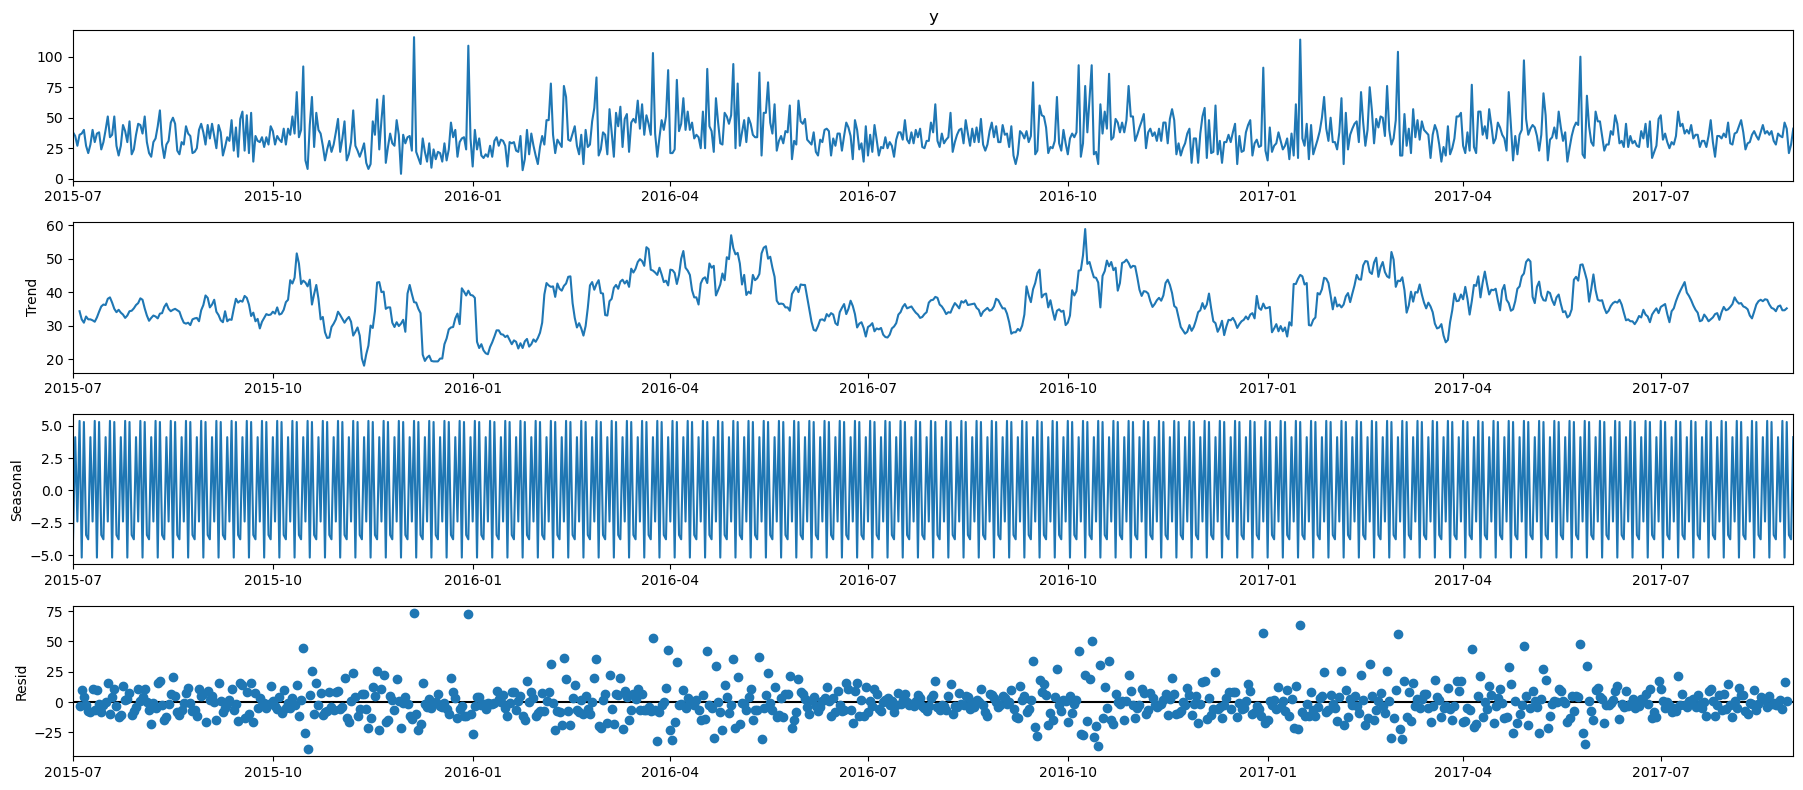

In [22]:
from pylab import rcParams
import statsmodels.api as sm

rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(d_df['y'], model='additive')
fig = decomposition.plot()

We apply an <strong>additive</strong> model when it seems that the trend is more linear and the seasonality and trend components seem to be constant over time .<br>
A <strong>multiplicative</strong> model is more appropriate when we are increasing (or decreasing) at a non-linear rate .

In [23]:
decomposition.seasonal[:20]

ds
2015-07-01   -3.758825
2015-07-02    4.104695
2015-07-03   -2.387652
2015-07-04    5.355214
2015-07-05   -5.163117
2015-07-06    5.271776
2015-07-07   -3.422091
2015-07-08   -3.758825
2015-07-09    4.104695
2015-07-10   -2.387652
2015-07-11    5.355214
2015-07-12   -5.163117
2015-07-13    5.271776
2015-07-14   -3.422091
2015-07-15   -3.758825
2015-07-16    4.104695
2015-07-17   -2.387652
2015-07-18    5.355214
2015-07-19   -5.163117
2015-07-20    5.271776
Name: seasonal, dtype: float64

## Exponentially Weighted Moving Average 

We just showed how to calculate the SMA based on some window. However, basic SMA has some weaknesses:
* Smaller windows will lead to more noise, rather than signal
* It will always lag by the size of the window
* It will never reach to full peak or valley of the data due to the averaging.
* Does not really inform you about possible future behavior, all it really does is describe trends in your data.
* Extreme historical values can skew your SMA significantly

In [24]:
d_df['6-month-SMA'] = d_df['y'].rolling(window=6).mean()
d_df['12-month-SMA'] = d_df['y'].rolling(window=12).mean()

EWMA will allow us to reduce the lag effect from SMA and it will put more weight on values that occured more recently (by applying more weight to the more recent values, thus the name). The amount of weight applied to the most recent values will depend on the actual parameters used in the EWMA and the number of periods given a window size.

* <strong>Span</strong> corresponds to what is commonly called an “N-day EW moving average”.
* <strong>Center of mass</strong> has a more physical interpretation and can be thought of in terms of span: $c=(s−1)/2$
* <strong>Half-life</strong> is the period of time for the exponential weight to reduce to one half.
* <strong>Alpha</strong> specifies the smoothing factor directly.

In [25]:
d_df['EWMA12'] = d_df['y'].ewm(span=30,adjust=False).mean()

<Axes: xlabel='ds'>

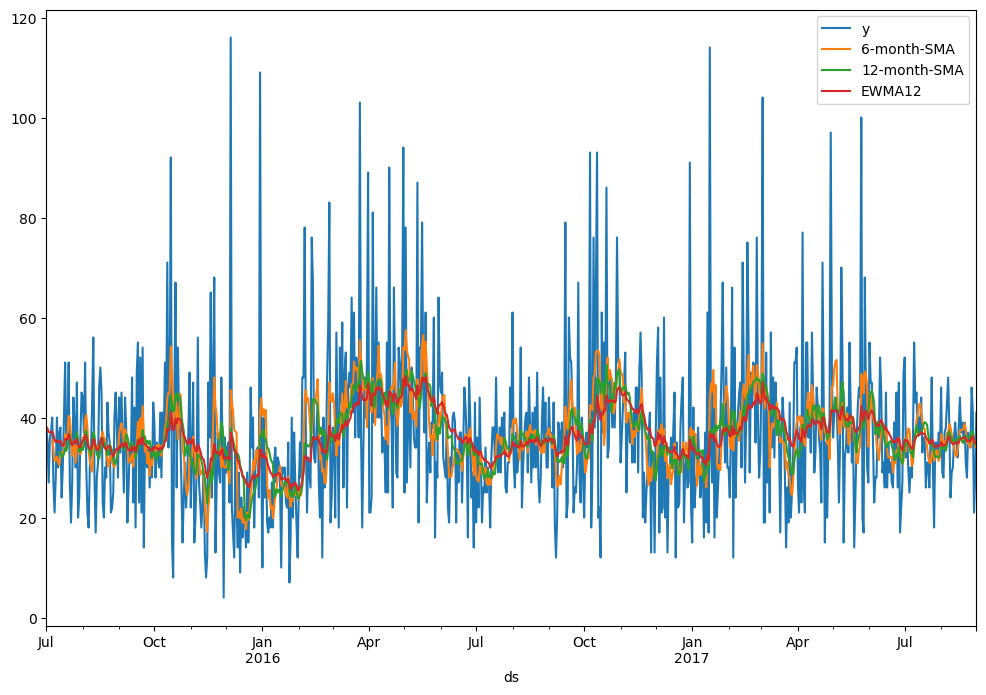

In [26]:
d_df.plot(figsize=(12,8))

# Holt-Winters Methods
In the previous section on <strong>Exponentially Weighted Moving Averages</strong> (EWMA) we applied <em>Simple Exponential Smoothing</em> using just one smoothing factor $\alpha$ (alpha). This failed to account for other contributing factors like trend and seasonality.

In this section we'll look at <em>Double</em> and <em>Triple Exponential Smoothing</em> with the <a href='https://otexts.com/fpp2/holt-winters.html'>Holt-Winters Methods</a>. 

In <strong>Double Exponential Smoothing</strong> (aka Holt's Method) we introduce a new smoothing factor $\beta$ (beta) that addresses trend:

\begin{split}l_t &= (1 - \alpha) l_{t-1} + \alpha x_t, & \text{    level}\\
b_t &= (1-\beta)b_{t-1} + \beta(l_t-l_{t-1}) & \text{    trend}\\
y_t &= l_t + b_t & \text{    fitted model}\\
\hat y_{t+h} &= l_t + hb_t & \text{    forecasting model (} h = \text{# periods into the future)}\end{split}

Because we haven't yet considered seasonal fluctuations, the forecasting model is simply a straight sloped line extending from the most recent data point. We'll see an example of this in upcoming lectures.

With <strong>Triple Exponential Smoothing</strong> (aka the Holt-Winters Method) we introduce a smoothing factor $\gamma$ (gamma) that addresses seasonality:

### Setting a DatetimeIndex Frequency
Note that our DatetimeIndex does not have a frequency. In order to build a Holt-Winters smoothing model, statsmodels needs to know the frequency of the data (whether it's daily, monthly etc.). Since observations occur at the start of each month, we'll use MS.<br>A full list of time series offset aliases can be found <a href='http://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#offset-aliases'>here</a>.

In [27]:
d_df.index.freq = 'D'

In [28]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

d_df['DESadd12'] = ExponentialSmoothing(d_df['y'], trend='add').fit().fittedvalues.shift(-1)
d_df.head()

,y,6-month-SMA,12-month-SMA,EWMA12,DESadd12
ds,,,,,
2015-07-01,38,NaN,NaN,38.000000,34.194456
2015-07-02,35,NaN,NaN,37.806452,34.234076
2015-07-03,27,NaN,NaN,37.109261,33.894976
2015-07-04,36,NaN,NaN,37.037696,33.995810
2015-07-05,37,NaN,NaN,37.035264,34.139001


In [29]:
d_df['TESmul12'] = ExponentialSmoothing(d_df['y'],trend='add',seasonal='add',seasonal_periods=7).fit().fittedvalues
d_df.head()

,y,6-month-SMA,12-month-SMA,EWMA12,DESadd12,TESmul12
ds,,,,,,
2015-07-01,38,NaN,NaN,38.000000,34.194456,29.916240
2015-07-02,35,NaN,NaN,37.806452,34.234076,38.300430
2015-07-03,27,NaN,NaN,37.109261,33.894976,31.685299
2015-07-04,36,NaN,NaN,37.037696,33.995810,39.051334
2015-07-05,37,NaN,NaN,37.035264,34.139001,28.452641


<Axes: xlabel='ds'>

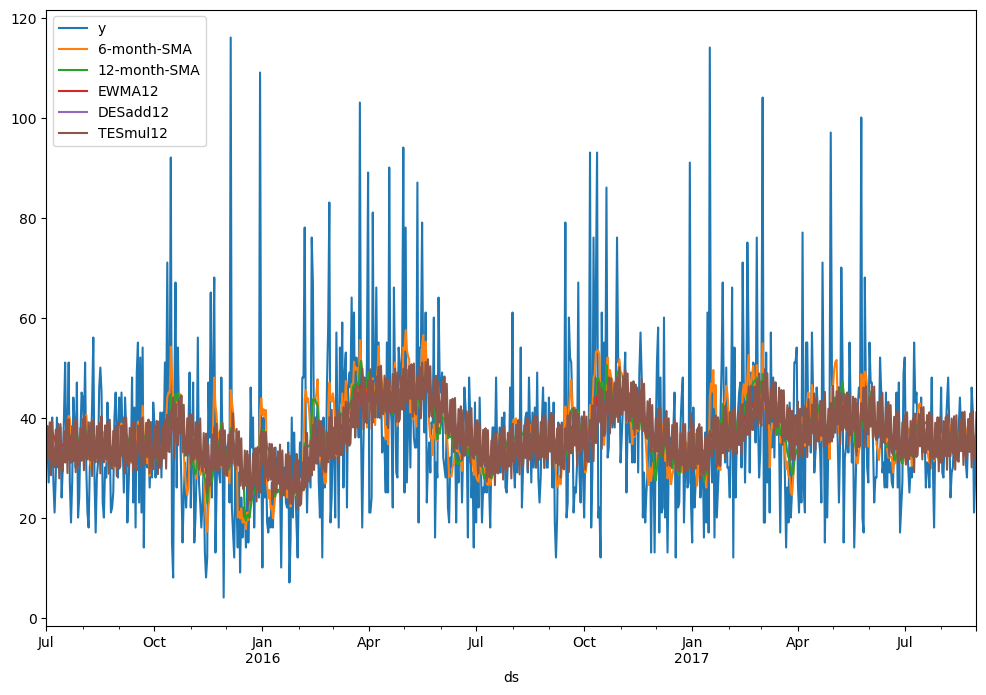

In [30]:
d_df.plot(figsize=(12,8))